## The effects of adversarial training in text-to-speech synthesis

Minimum generation error (MGE) training vs Adversarial training. Generated audio samples are available at the middle of the notebook.

Code: https://github.com/r9y9/gantts

### Refereneces

- [Yuki Saito, Shinnosuke Takamichi, Hiroshi Saruwatari, "Statistical Parametric Speech Synthesis Incorporating Generative Adversarial Networks", arXiv:1709.08041 [cs.SD], Sep. 2017](https://arxiv.org/abs/1709.08041)
- [Yuki Saito, Shinnosuke Takamichi, and Hiroshi Saruwatari, "Training algorithm to deceive anti-spoofing verification for DNN-based text-to-speech synthesis," IPSJ SIG Technical Report, 2017-SLP-115, no. 1, pp. 1-6, Feb., 2017. (in Japanese)](http://sython.org/papers/SIG-SLP/saito201702slp.pdf)
- [Yuki Saito, Shinnosuke Takamichi, and Hiroshi Saruwatari, "Voice conversion using input-to-output highway networks," IEICE Transactions on Information and Systems, Vol.E100-D, No.8, pp.1925--1928, Aug. 2017](https://www.jstage.jst.go.jp/article/transinf/E100.D/8/E100.D_2017EDL8034/_article)

In [1]:
%pylab inline
rcParams["figure.figsize"] = (16,5)

import sys
sys.path.insert(0, "..")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch

from scipy.io import wavfile
import pyworld
import pysptk

import IPython
from IPython.display import Audio

import librosa
import librosa.display

from nnmnkwii import preprocessing as P
from glob import glob
from os.path import join

import gantts
from hparams import tts_acoustic as hp_acoustic
from hparams import tts_duration as hp_duration

In [3]:
# Depends on experimental conditions
data_dir = "../data/cmu_arctic_tts_order24"
chechpoints_dir = "../checkpoints/tts_order24/"
duration_epoch = 100
acoustic_epoch = 50

In [4]:
X_min = {}
X_max = {}
Y_mean = {}
Y_var = {}
Y_std = {}

for typ in ["acoustic", "duration"]:
    X_min[typ] = np.load(join(data_dir, "X_{}_data_min.npy".format(typ)))
    X_max[typ] = np.load(join(data_dir, "X_{}_data_max.npy".format(typ)))
    Y_mean[typ] = np.load(join(data_dir, "Y_{}_data_mean.npy".format(typ)))
    Y_var[typ] = np.load(join(data_dir, "Y_{}_data_var.npy".format(typ)))
    Y_std[typ] = np.sqrt(Y_var[typ])

## Models

In [5]:
models = {"baseline": {}, "gan": {}}

for method_typ in ["baseline", "gan"]:
    models[method_typ] = {"duration":  {}, "acoustic": {}}
    for (typ, epoch) in zip(["duration", "acoustic"], [duration_epoch, acoustic_epoch]):
        # Set missing hyper params from data
        hp = hp_acoustic if typ == "acoustic" else hp_duration
        if hp.generator_params["in_dim"] is None:
            hp.generator_params["in_dim"] = X_min[typ].shape[-1]
        if hp.generator_params["out_dim"] is None:
            hp.generator_params["out_dim"] = Y_mean[typ].shape[-1]
    
        models[method_typ][typ] = getattr(gantts.models, hp.generator)(**hp.generator_params)
        print("Model for {}, {}\n".format(method_typ, typ), models[method_typ][typ])
        
        checkpoint_path = join(chechpoints_dir, "tts_{}/{}/checkpoint_epoch{}_Generator.pth".format(
            typ, method_typ, epoch))
        print("Load checkpoint from: {}".format(checkpoint_path))
        
        checkpoint = torch.load(checkpoint_path)
        models[method_typ][typ].load_state_dict(checkpoint["state_dict"])
        models[method_typ][typ].eval()

Model for baseline, duration
 LSTMRNN (
  (lstm): LSTM(416, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (hidden2out): Linear (1024 -> 5)
  (sigmoid): Sigmoid ()
)
Load checkpoint from: ../checkpoints/tts_order24/tts_duration/baseline/checkpoint_epoch100_Generator.pth
Model for baseline, acoustic
 MLP (
  (layers): ModuleList (
    (0): Linear (425 -> 512)
    (1): Linear (512 -> 512)
    (2): Linear (512 -> 512)
  )
  (last_linear): Linear (512 -> 82)
  (relu): LeakyReLU (0.01, inplace)
  (sigmoid): Sigmoid ()
  (dropout): Dropout (p = 0.5)
)
Load checkpoint from: ../checkpoints/tts_order24/tts_acoustic/baseline/checkpoint_epoch50_Generator.pth
Model for gan, duration
 LSTMRNN (
  (lstm): LSTM(416, 512, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (hidden2out): Linear (1024 -> 5)
  (sigmoid): Sigmoid ()
)
Load checkpoint from: ../checkpoints/tts_order24/tts_duration/gan/checkpoint_epoch100_Generator.pth
Model for gan, acoustic
 MLP (
  

## Compare generated audio samples

Baseline vs GAN

In [6]:
from evaluation_tts import tts_from_label, get_lab_files, get_wav_files

In [7]:
label_dir = "../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/"
wav_dir = "../nnmnkwii_gallery/data/slt_arctic_full_data/wav/"

test_label_paths = get_lab_files(data_dir,label_dir, test=True)
test_wav_paths = get_wav_files(data_dir, wav_dir, test=True)
print(len(test_label_paths))

5


### Apply acoustic model only

In [8]:
for wav_path, label_path in zip(test_wav_paths, test_label_paths):
    print("Input label:", label_path)
    
    fs, waveform = wavfile.read(wav_path)
    
    ty = "baseline"
    baseline_waveform, mgc_baseline, _, _, _ = tts_from_label(
        models[ty], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=False, post_filter=False)
    ty = "gan"
    gan_waveform, mgc_gan, _, _, _ = tts_from_label(
        models[ty], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=False, post_filter=False)
    
    IPython.display.display(Audio(waveform, rate=fs))
    IPython.display.display(Audio(baseline_waveform, rate=fs))
    IPython.display.display(Audio(gan_waveform, rate=fs))

Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0535.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0536.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0537.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0538.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0539.lab


### Apply acoustic model + duration model

In [9]:
for wav_path, label_path in zip(test_wav_paths, test_label_paths):
    print("Input label:", label_path)
    
    fs, waveform = wavfile.read(wav_path)
    
    ty = "baseline"
    baseline_waveform, mgc_baseline, _, _, _ = tts_from_label(
        models[ty], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=True, post_filter=False)
    ty = "gan"
    gan_waveform, mgc_gan, _, _, _ = tts_from_label(
        models[ty], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=True, post_filter=False)
     
    IPython.display.display(Audio(waveform, rate=fs))
    IPython.display.display(Audio(baseline_waveform, rate=fs))
    IPython.display.display(Audio(gan_waveform, rate=fs))

Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0535.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0536.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0537.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0538.lab


Input label: ../nnmnkwii_gallery/data/slt_arctic_full_data/label_state_align/arctic_b0539.lab


## Global variances

In [10]:
def compute_mgc_from_waveform(x, fs):
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=hp_acoustic.frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)
    alpha = pysptk.util.mcepalpha(fs)
    mc = pysptk.sp2mc(spectrogram, order=hp_acoustic.order, alpha=alpha)   
    hop_length = int(fs * (hp_acoustic.frame_period * 0.001))
    modfs = fs / hop_length
    mc = P.modspec_smoothing(mc, modfs, cutoff=50)
    return mc

def vis_gv(label_path, wav_path):    
    fs, waveform = wavfile.read(wav_path)
    mgc_natural = compute_mgc_from_waveform(waveform, fs)

    waveform_baseline, mgc_baseline, _, _, _ = tts_from_label(
        models["baseline"], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=True, post_filter=False)
    waveform_gan, mgc_gan, _, _, _ = tts_from_label(
        models["gan"], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=True, post_filter=False)

    figure(figsize=(16,6))
    plot(np.var(mgc_natural, axis=0), "--", linewidth=2, label="Natural: global variances")
    plot(np.var(mgc_baseline, axis=0), linewidth=2, label="Baseline: global variances")
    plot(np.var(mgc_gan, axis=0), linewidth=2, label="GAN: global variances")
    legend(prop={"size": 18})
    yscale("log")
    xlabel("Dimention", fontsize=16)
        
    for x, name in [(waveform, "Natural"),
                   (waveform_baseline, "Baseline"),
                   (waveform_gan, "GAN")]:
        print(name)
        IPython.display.display(Audio(x, rate=fs))

Natural


Baseline


GAN


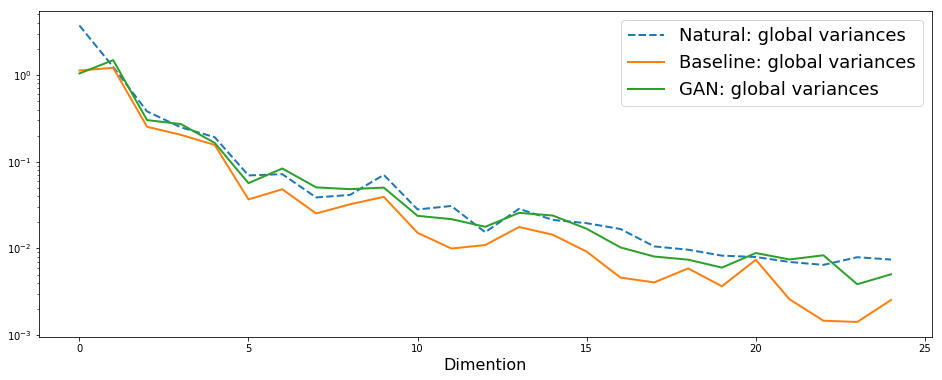

In [11]:
idx = 0
label_path, wav_path = test_label_paths[idx], test_wav_paths[idx]
vis_gv(label_path, wav_path)

Natural


Baseline


GAN


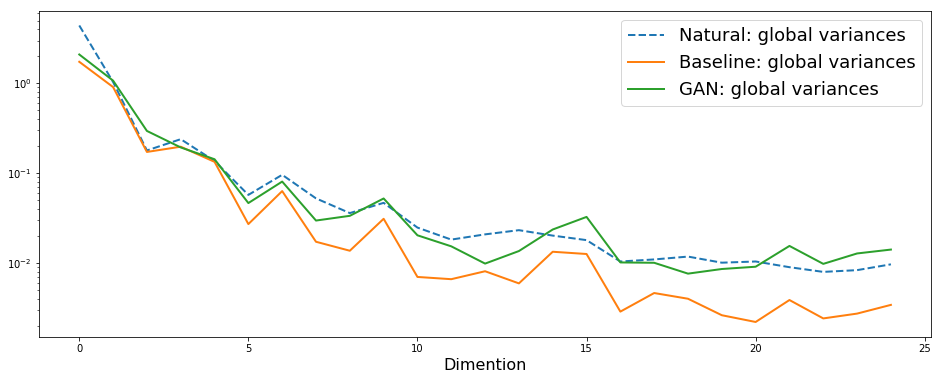

In [12]:
idx = 1
label_path, wav_path = test_label_paths[idx], test_wav_paths[idx]
vis_gv(label_path, wav_path)

Natural


Baseline


GAN


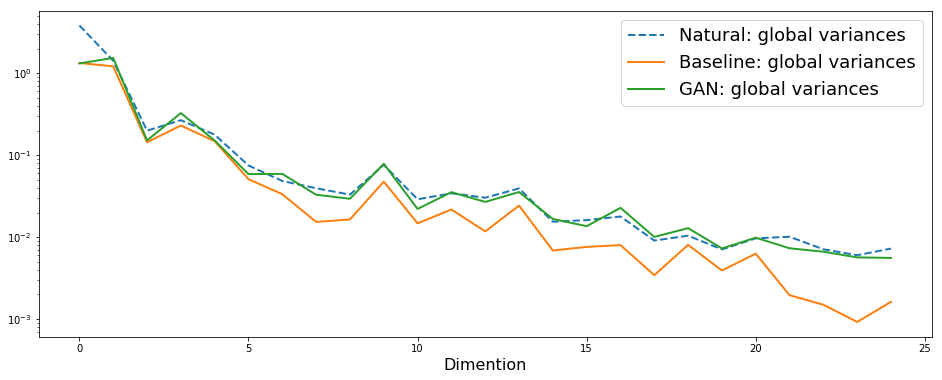

In [13]:
idx = 2
label_path, wav_path = test_label_paths[idx], test_wav_paths[idx]
vis_gv(label_path, wav_path)

## Scatter plots

In [14]:
def scatter_plots(label_path, wav_path):
    fs, waveform = wavfile.read(wav_path)
    mgc_natural = compute_mgc_from_waveform(waveform, fs)

    waveform_baseline, mgc_baseline, _, _, _ = tts_from_label(
        models["baseline"], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=True, post_filter=False)
    waveform_gan, mgc_gan, _, _, _ = tts_from_label(
        models["gan"], label_path, X_min, X_max, Y_mean, Y_std,
        apply_duration_model=True, post_filter=False)

    # For order=24
    dim_pairs = [(1, 3), (11, 13), (21, 23)]
    # For order=59
    # dim_pairs = [(1, 3), (11, 13), (41, 43), (51, 53), (55, 58)]
    figure(figsize=(16,6*len(dim_pairs)))

    for pair_idx, (i, j) in enumerate(dim_pairs):
        for idx, features in enumerate([mgc_natural, mgc_baseline, mgc_gan]):
            subplot(len(dim_pairs), 3, pair_idx*3 + 1+idx)
            c = "black" if idx == 0 else "gray" if idx == 1 else "blue"
            scatter(features[:,i], features[:,j], marker="x", c=c)            
            xlim(np.min(mgc_natural[:,i])-0.03, np.max(mgc_natural[:,i])+0.03)
            ylim(np.min(mgc_natural[:,j])-0.03, np.max(mgc_natural[:,j])+0.03)
            xlabel("{}-th mel-cepstrum coefficients".format(i), fontsize=18)
            if idx == 0:
                ylabel("{}-th mel-cepstrum coefficients".format(j), fontsize=18)

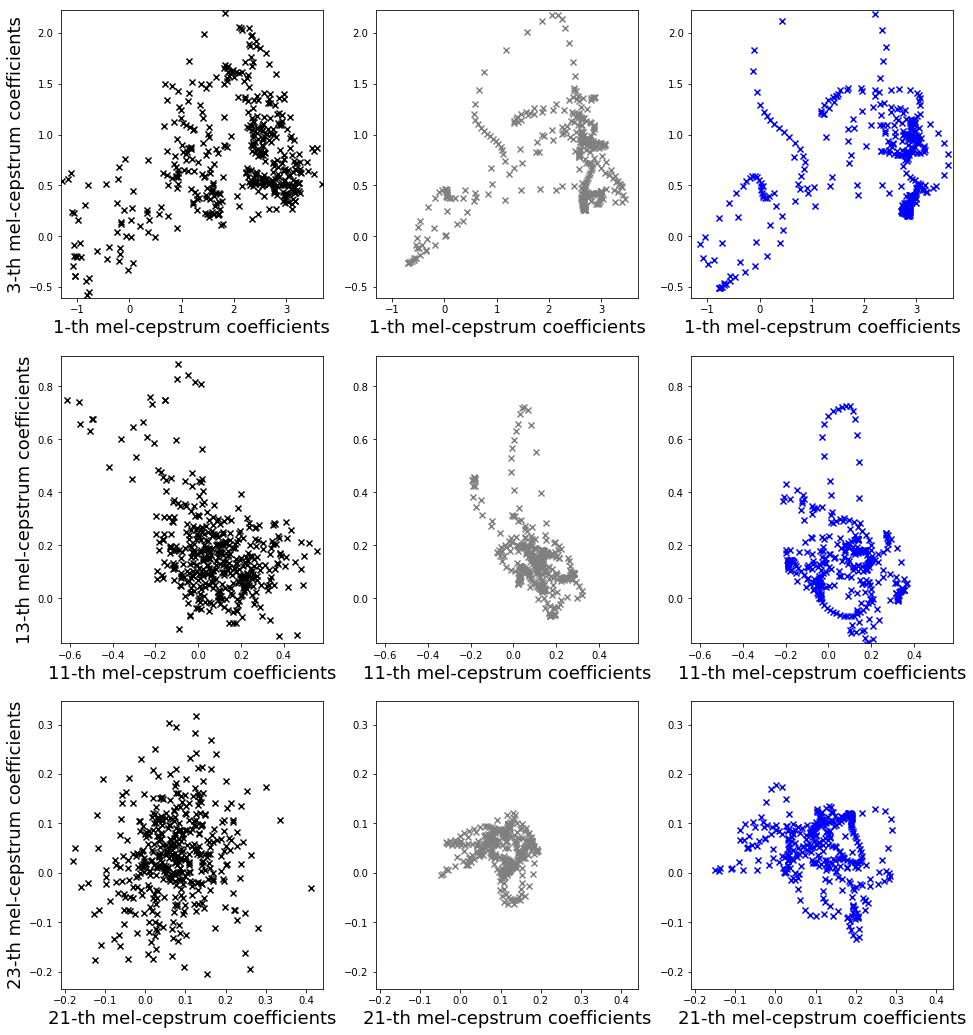

In [15]:
idx = 0
label_path, wav_path = test_label_paths[idx], test_wav_paths[idx]
scatter_plots(label_path, wav_path)

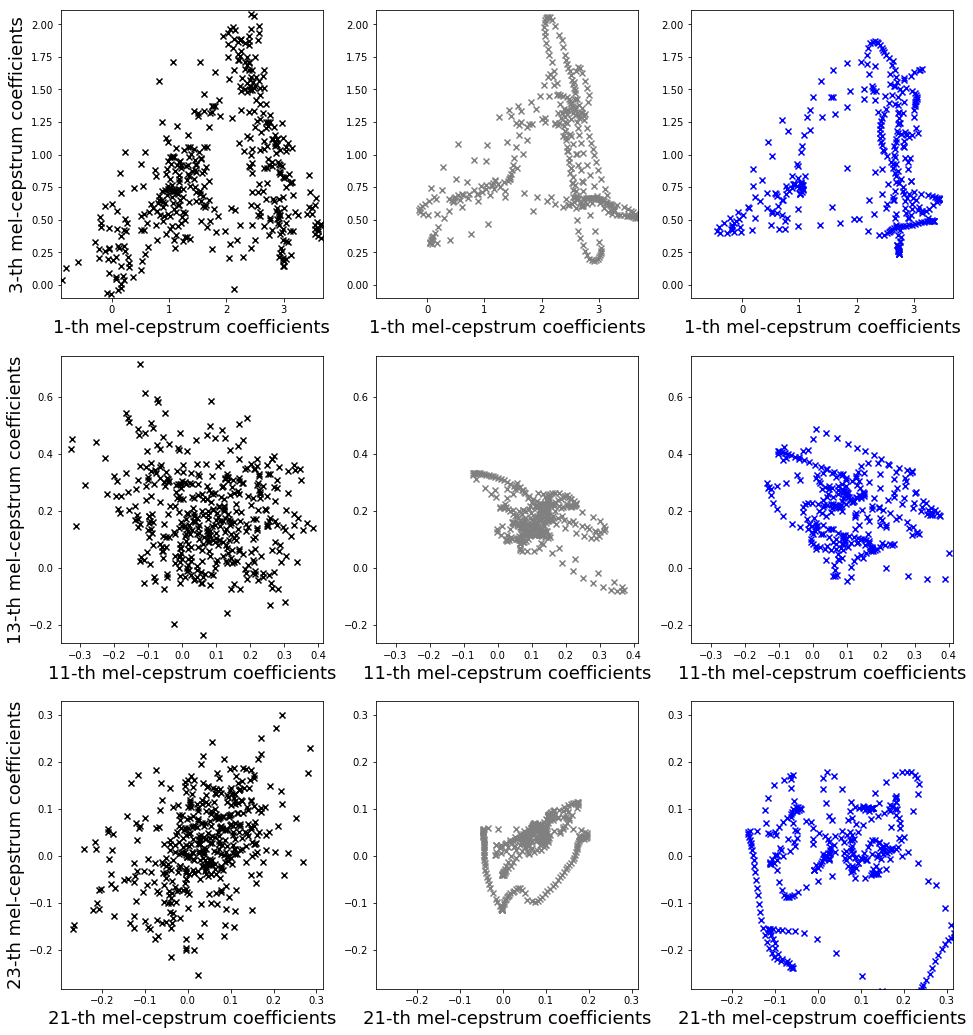

In [16]:
idx = 1
label_path, wav_path = test_label_paths[idx], test_wav_paths[idx]
scatter_plots(label_path, wav_path)

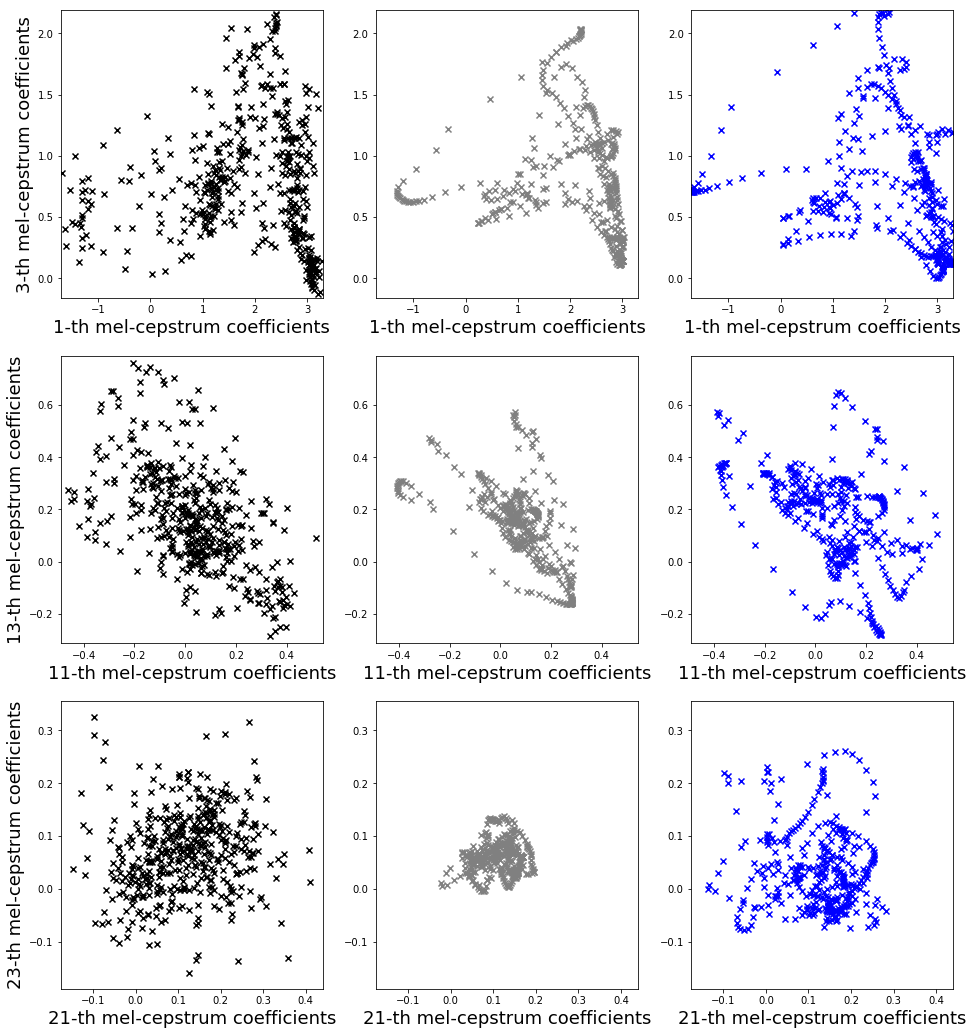

In [17]:
idx = 2
label_path, wav_path = test_label_paths[idx], test_wav_paths[idx]
scatter_plots(label_path, wav_path)

### Modulation spectrum

In [18]:
from tqdm import tnrange

ms_fftlen = 4096
hop_length = int(fs * (hp_acoustic.frame_period * 0.001))
modfs = fs / hop_length
ms_freq = np.arange(ms_fftlen//2 + 1)/ms_fftlen * modfs

In [19]:
eval_label_paths = get_lab_files(data_dir,label_dir, test=False)
eval_wav_paths = get_wav_files(data_dir, wav_dir, test=False)
print(len(eval_label_paths))

127


In [20]:
def mean_modspec(label_files, wav_files, models=None):
    mss = []
    for idx in tnrange(len(label_files)):
        label_path, wav_path = label_files[idx], wav_files[idx]
        if models is not None:
            _, mgc, _, _, _ = tts_from_label(
                models, label_path, X_min, X_max, Y_mean, Y_std,
                apply_duration_model=True, post_filter=False)
        else:       
            fs, waveform = wavfile.read(wav_path)
            mgc = compute_mgc_from_waveform(waveform, fs)
            
        ms = np.log(P.modspec(mgc, n=ms_fftlen))
        mss.append(ms)
    return np.mean(np.array(mss), axis=(0,))

In [21]:
ms_baseline = mean_modspec(eval_label_paths, eval_wav_paths, models=models["baseline"])
ms_gan = mean_modspec(eval_label_paths, eval_wav_paths, models=models["gan"])
ms = mean_modspec(eval_label_paths, eval_wav_paths)

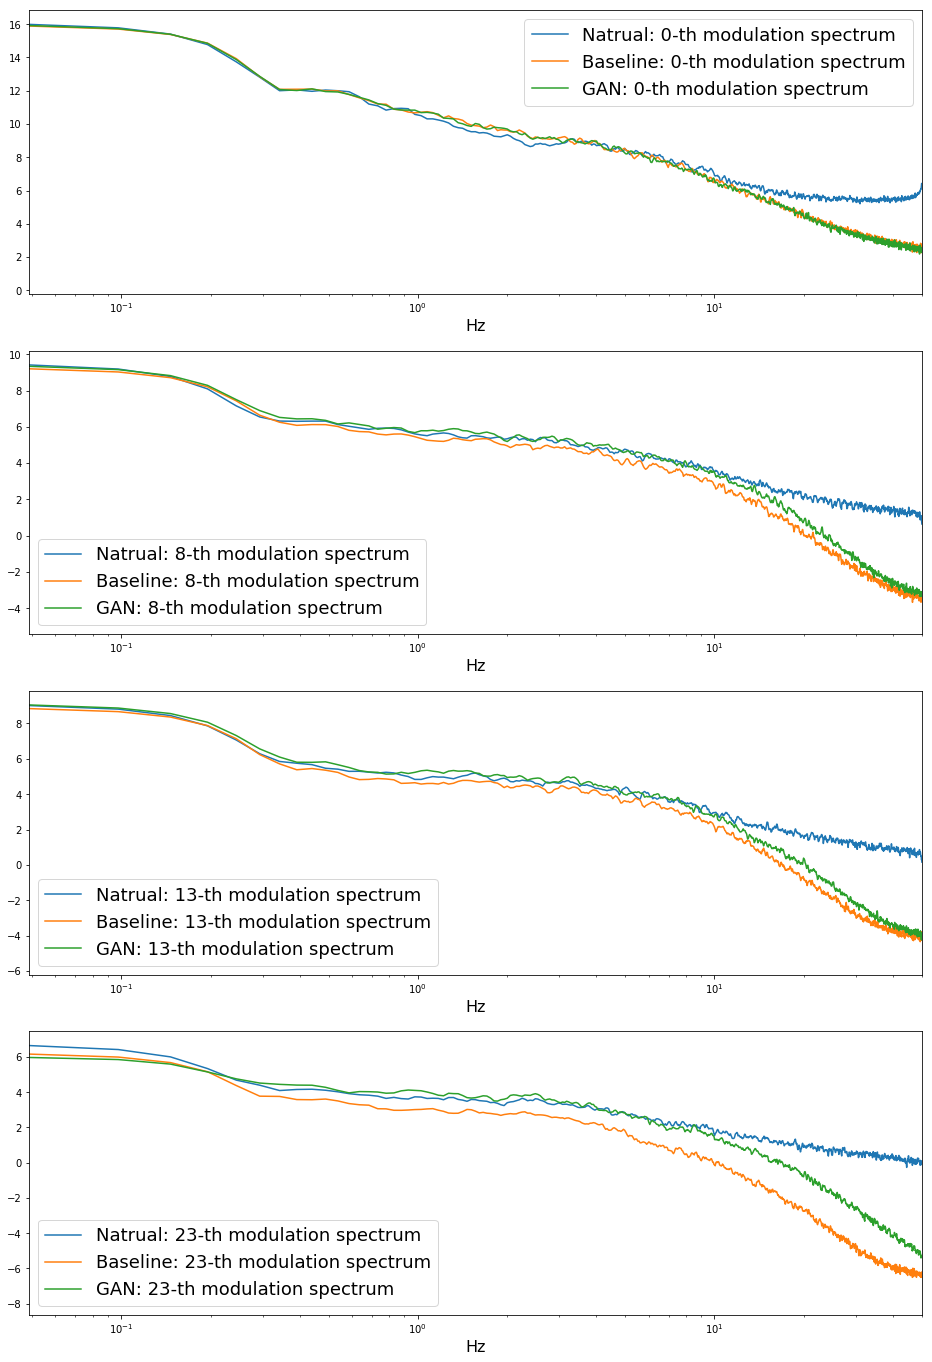

In [22]:
def vis_ms(dim=7):
    plot(ms_freq, ms[:,dim], "-", label="Natrual: {}-th modulation spectrum".format(dim))
    plot(ms_freq, ms_baseline[:,dim], label="Baseline: {}-th modulation spectrum".format(dim))
    plot(ms_freq, ms_gan[:,dim], label="GAN: {}-th modulation spectrum".format(dim))
    xscale("log")
    xlabel("Hz", fontsize=16)
    xlim(0, 50) # 50hz cutoff
    # xlim(0, 100)
    legend(prop={"size": 18})

# For order=24
dims = [0, 8, 13, 23]
# For order=59
# dims = [0, 8, 13, 23, 30, 40, 50]
figure(figsize=(16, 6*len(dims)))
for idx, dim in enumerate(dims):
    subplot(len(dims), 1, idx+1)
    vis_ms(dim)